In [2]:
%pylab inline --no-import-all
import keras
from keras.datasets import mnist
import progressbar

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [3]:
(train, train_labels), (test, test_labels) = mnist.load_data()
train_samples = train.shape[0]
test_samples = test.shape[0]
img_shape = (28*28,)

train = train.reshape((train_samples, *img_shape)) / 255.0
test = test.reshape((test_samples, *img_shape)) / 255.0

In [16]:
from keras.layers import Input, Dense, Activation
from keras.callbacks import LambdaCallback
from keras.models import Model


encoded_dim = 64  # dimensionality of encoded images

input_layer = Input(shape=img_shape)
encoded_layer = Dense(encoded_dim, activation='relu')(input_layer)
decoded_layer = Dense(img_shape[0], activation='sigmoid')(encoded_layer)

autoencoder = Model(input_layer, decoded_layer)

encoder = Model(input_layer, encoded_layer)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
def train_test(model, train_data, epochs, log_step, plot_samples, batch_size):
    samples = test[(np.random.randint(0, test_samples, size=plot_samples))]
    f = lambda epoch: int(epoch / log_step) # mapping from epoch number to test number
    metrics = {'acc': 0, 'loss': 0}
    
    def plot_test(axes, epoch):
        predictions = autoencoder.predict(samples)
        axes[0, f(epoch)].set_title('epoch ' + str(epoch), size=16)
        for i in range(plot_samples):
            axes[i, f(epoch)].imshow(predictions[i].reshape((28, 28)))
            axes[i, f(epoch)].axis('off')
        
    
    fig, axes = plt.subplots(plot_samples, f(epochs)+1, figsize=(16, 10))
    for i, img in enumerate(samples):
        axes[i, 0].imshow(img.reshape((28, 28)))
        axes[i, 0].axis('off')

    axes[0, 0].set_title('original', size=16)

  
    acc_widget = progressbar.FormatCustomText('loss: %(loss)f, acc: %(acc)f', metrics)
    bar = progressbar.ProgressBar(max_value=epochs, term_width=100,
                                  widgets=['trained: ', progressbar.Counter(),
                                           '/', str(epochs), ' | ', acc_widget,
                                           ' ', progressbar.Bar()])

    def update_metrics(epoch):
        metrics['loss'], metrics['acc'] = model.evaluate(test, test, verbose=False)
        acc_widget.update_mapping()
        bar.update(epoch)
        

    metrics_logger = LambdaCallback(on_epoch_begin=lambda epoch, logs: update_metrics(epoch))
    progress_logger = LambdaCallback(on_epoch_end=lambda epoch, logs: bar.update(epoch+1))

    plot_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: (plot_test(axes, epoch+1)
                                          if (epoch+1) % log_step == 0 and epoch >= (log_step-1) else 0))

    model.fit(train_data, train_data,
                    batch_size=batch_size, epochs=epochs,
                    callbacks=[plot_callback, progress_logger, metrics_logger],
                    verbose=False)

trained: 20/20 | loss: 0.092022, acc: 0.813414 |###################################################|

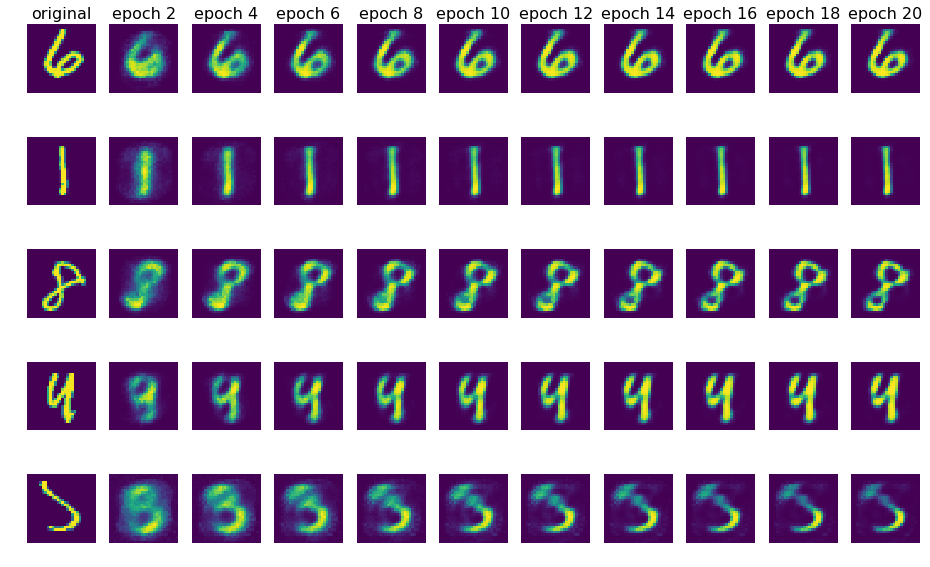

In [18]:
epochs = 20           # epochs count to train the model
log_step = 2          # how frequently plot training results (1 = each epoch)
plot_samples = 5      # number of samples to plot
batch_size = 100

train_test(autoencoder, train, epochs, log_step, plot_samples, batch_size)

In [19]:
def plot_encoded_representation(encoder, plot_samples):
    samples = test[(np.random.randint(0, test_samples, size=plot_samples))]
    encoded_samples = encoder.predict(samples)

    fig, axes = plt.subplots(2, plot_samples, figsize=(16, 6))

    for i in range(plot_samples):
        axes[0, i].imshow(samples[i].reshape(28, 28))
        axes[0, i].axis('off')
        axes[1, i].imshow(encoded_samples[i].reshape((8, 8)))

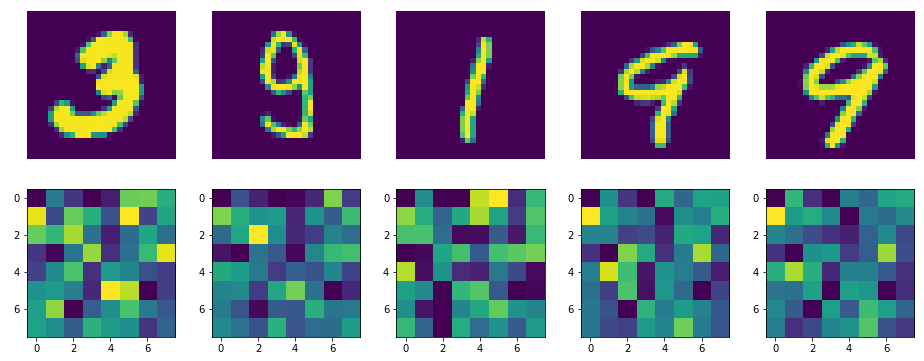

In [20]:
plot_samples = 5
plot_encoded_representation(encoder, plot_samples)